In [1]:
"""
그냥 패키지 전에 쓰던거 가지고왔고, 당연히 추가하고 빼도됩니다. 
"""
# loading packages
import pandas as pd
import numpy as np

# plotting packages
import matplotlib.pyplot as plt

# PCA packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from functools import reduce
from sklearn.model_selection import TimeSeriesSplit

import pandas_datareader.data as web  # module for reading datasets directly from the web
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_monthly = pd.read_csv('/content/drive/MyDrive//시계열분석/Monthly_df.csv')

In [5]:
df_daily = pd.read_csv('/content/drive/MyDrive//시계열분석/Daily_df.csv')

In [6]:
df_monthly[:156]

,Unnamed: 0,Fine_Dust(PM10),Ultrafine_Dust(PM25)
0,2008-01-31,60.908602,36.702957
1,2008-02-29,62.609195,27.833333
2,2008-03-31,70.224462,32.842742
3,2008-04-30,72.926389,34.063889
4,2008-05-31,60.973118,24.801075
...,...,...,...
151,2020-08-31,22.833333,14.458333
152,2020-09-30,19.197222,10.666667
153,2020-10-31,33.469086,17.225806
154,2020-11-30,41.677778,23.965278


In [7]:
df_daily.set_index('Unnamed: 0', inplace=True)

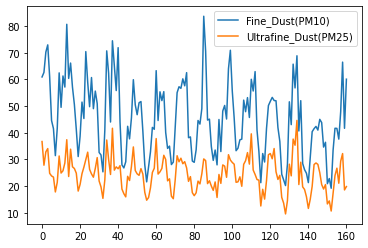

In [8]:
df_monthly.plot()

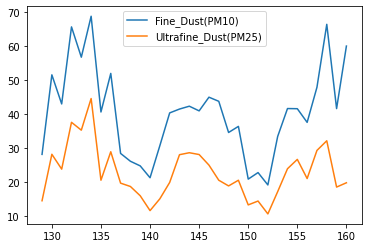

In [9]:
df_monthly[-32:].plot()

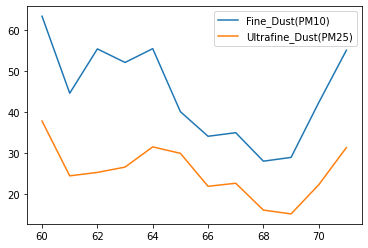

In [10]:
df_monthly[60:72].plot()

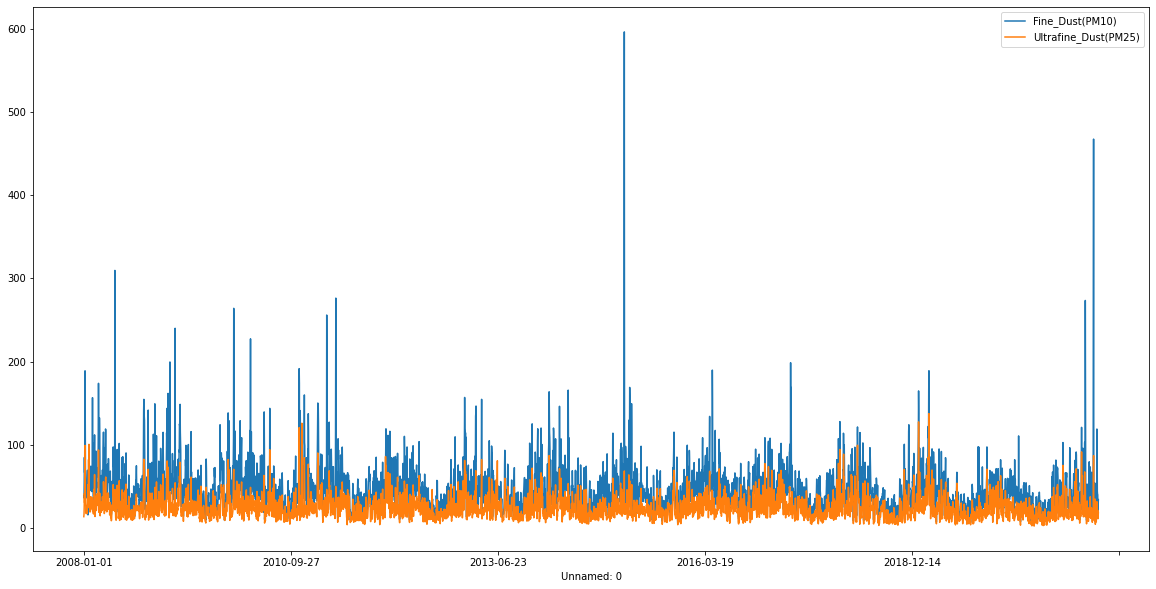

In [11]:
df_daily.plot(figsize=(20,10))

In [12]:
df_monthly.iloc[:,2]

0      36.702957
1      27.833333
2      32.842742
3      34.063889
4      24.801075
         ...    
156    21.077957
157    29.354167
158    32.194892
159    18.568056
160    19.833333
Name: Ultrafine_Dust(PM25), Length: 161, dtype: float64

In [13]:
df_monthly.iloc[:,1:3]

,Fine_Dust(PM10),Ultrafine_Dust(PM25)
0,60.908602,36.702957
1,62.609195,27.833333
2,70.224462,32.842742
3,72.926389,34.063889
4,60.973118,24.801075
...,...,...
156,37.612903,21.077957
157,47.941964,29.354167
158,66.463710,32.194892
159,41.663889,18.568056


In [14]:
df_monthly.iloc[:,1:3][1:12]

,Fine_Dust(PM10),Ultrafine_Dust(PM25)
1,62.609195,27.833333
2,70.224462,32.842742
3,72.926389,34.063889
4,60.973118,24.801075
5,44.581944,23.811111
6,41.548387,23.381720
7,31.422043,17.813172
8,41.723611,21.441667
9,62.434140,31.290323
10,49.523611,24.897222


In [15]:
df_monthly.iloc[:,1:3].iloc[12]

Fine_Dust(PM10)         57.119624
Ultrafine_Dust(PM25)    28.686828
Name: 12, dtype: float64

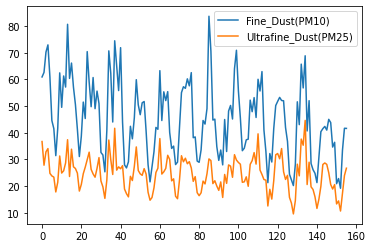

In [16]:
df_monthly[:156].plot()

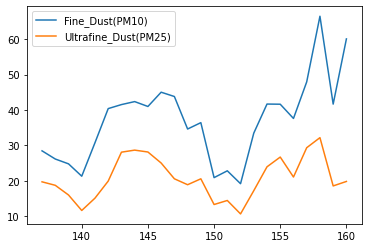

In [17]:
df_monthly[-24:].plot()

In [25]:
dataset = df_monthly[:156].iloc[:,1:3]
seqLength = 12 # window size 
dataDim = 1 
hiddenDim = 10 
outputDim = 1
lr = 0.01
iterations = 500


def buildDataSet(timeSeries, seqLength):
    xdata = []
    ydata = [] 
    for i in range(0, len(timeSeries)-seqLength):
        tx = timeSeries[i:i+seqLength]
        ty = timeSeries.iloc[i+seqLength]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)


trainSize = int(len(dataset)*0.8)
trainSet = dataset.iloc[0:trainSize]
testSet = dataset.iloc[trainSize-seqLength:]

trainX, trainY = buildDataSet(trainSet, seqLength)
testX, testY = buildDataSet(testSet, seqLength)

with tf.device('/device:GPU:0'):
    model = keras.Sequential()

    model.add(layers.SimpleRNN(units=10, 
                            activation='tanh',
                            input_shape=[12,2]))
    model.add(layers.Dense(2))
    model.summary()

    # 모델 학습과정 설정 
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    # 모델 트레이닝 
    hist = model.fit(trainX, trainY, epochs=1000, batch_size=16)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                130       
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
7/7 [==============================] - 1s 5ms/step - loss: 1509.8206 - mae: 35.9723
Epoch 2/1000
7/7 [==============================] - 0s 5ms/step - loss: 1499.4227 - mae: 35.8064
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 1486.5282 - mae: 35.5962
Epoch 4/1000
7/7 [==============================] - 0s 4ms/step - loss: 1472.4746 - mae: 35.3620
Epoch 5/1000
7/7 [==============================] - 0s 4ms/step 

In [26]:
# 모델 테스트 
res = model.evaluate(testX, testY, batch_size=16)
print("loss",res[0],"mae",res[1])

2/2 [==============================] - 0s 6ms/step - loss: 73.7719 - mae: 6.9431
loss 73.77186584472656 mae 6.943147659301758


In [27]:
#7 모델 사용
xhat = testX
yhat = model.predict(xhat)
print(testY)
print(yhat)

print("Evaluate : {}".format(np.average((yhat - testY)**2)))

1/1 [==============================] - 0s 112ms/step
[[41.95564516 22.50403226]
 [36.74166667 24.03611111]
 [24.45295699 15.79166667]
 [22.31854839 13.63306452]
 [20.20277778  9.58055556]
 [28.18951613 14.54301075]
 [51.59861111 28.21805556]
 [43.03494624 23.84811828]
 [65.70833333 37.625     ]
 [56.79464286 35.31845238]
 [68.84408602 44.625     ]
 [40.66527778 20.58888889]
 [52.02016129 28.96236559]
 [28.46944444 19.725     ]
 [26.16532258 18.7405914 ]
 [24.80107527 16.0094086 ]
 [21.3125     11.64027778]
 [30.76478495 15.11962366]
 [40.39444444 19.93333333]
 [41.52688172 28.09543011]
 [42.36962366 28.6733871 ]
 [40.99425287 28.14367816]
 [45.02150538 25.03360215]
 [43.80694444 20.58333333]
 [34.63172043 18.90725806]
 [36.42777778 20.57777778]
 [20.90994624 13.32123656]
 [22.83333333 14.45833333]
 [19.19722222 10.66666667]
 [33.46908602 17.22580645]
 [41.67777778 23.96527778]
 [41.63037634 26.71370968]]
[[49.317924 27.314348]
 [48.536526 26.914835]
 [39.33526  22.010756]
 [31.082138 1

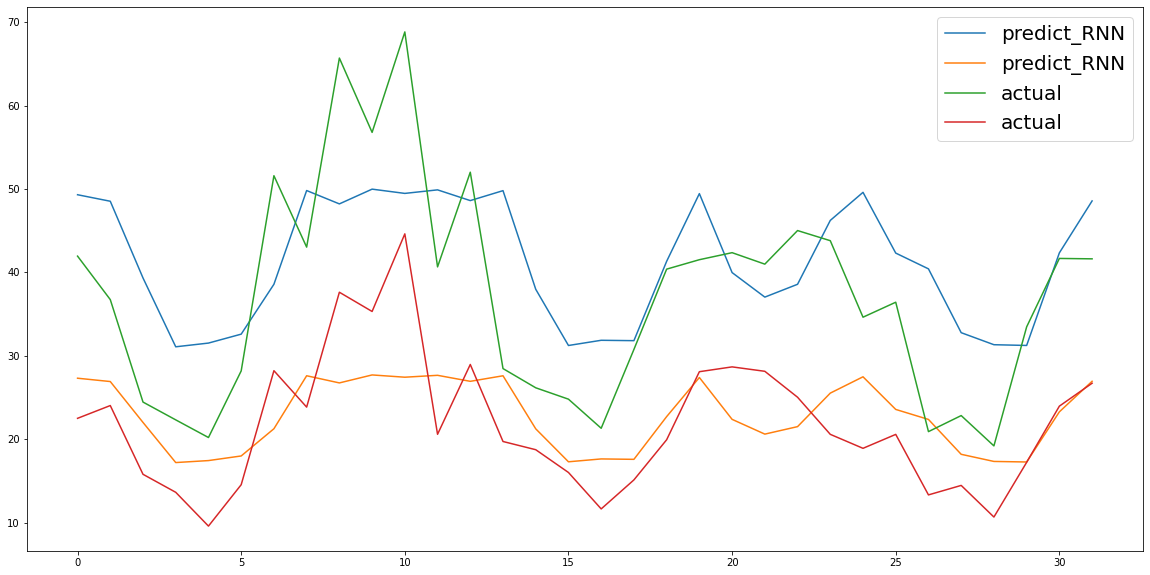

In [29]:
plt.figure(figsize=(20,10))
plt.plot(yhat, label = "predict_RNN")
plt.plot(testY,label = "actual")

plt.legend(prop={'size': 20})

In [50]:
#LSTM
model2 = keras.Sequential()

model2.add(layers.LSTM(units=10, 
                           activation='tanh',
                           input_shape=[12,2]))

#model2.add(layers.Dense(7))
model2.add(layers.Dense(5))
model2.add(layers.Dense(2))

model2.summary()


# 모델 학습과정 설정 
model2.compile(loss='mse', optimizer='adam', metrics=['mae'])

# 모델 트레이닝 
hist = model2.fit(trainX, trainY, epochs=1000, batch_size=16)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10)                520       
                                                                 
 dense_11 (Dense)            (None, 5)                 55        
                                                                 
 dense_12 (Dense)            (None, 2)                 12        
                                                                 
Total params: 587
Trainable params: 587
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
7/7 [==============================] - 1s 4ms/step - loss: 1509.6788 - mae: 35.8371
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 1505.5038 - mae: 35.7941
Epoch 3/1000
7/7 [==============================] - 0s 3ms/step - loss: 1501.3248 - mae: 35.7513
Epoch 4/1000
7/7 [===========

In [51]:
# 모델 테스트 
res2 = model2.evaluate(testX, testY, batch_size=16)
print("loss",res2[0],"mae",res2[1])

2/2 [==============================] - 1s 5ms/step - loss: 54.6117 - mae: 5.7058
loss 54.61166763305664 mae 5.705843925476074


In [52]:
#7 모델 사용
xhat2 = testX
yhat2 = model2.predict(xhat)
print(testY)
print(yhat2)

print("Evaluate : {}".format(np.average((yhat2 - testY)**2)))

1/1 [==============================] - 0s 345ms/step
[[41.95564516 22.50403226]
 [36.74166667 24.03611111]
 [24.45295699 15.79166667]
 [22.31854839 13.63306452]
 [20.20277778  9.58055556]
 [28.18951613 14.54301075]
 [51.59861111 28.21805556]
 [43.03494624 23.84811828]
 [65.70833333 37.625     ]
 [56.79464286 35.31845238]
 [68.84408602 44.625     ]
 [40.66527778 20.58888889]
 [52.02016129 28.96236559]
 [28.46944444 19.725     ]
 [26.16532258 18.7405914 ]
 [24.80107527 16.0094086 ]
 [21.3125     11.64027778]
 [30.76478495 15.11962366]
 [40.39444444 19.93333333]
 [41.52688172 28.09543011]
 [42.36962366 28.6733871 ]
 [40.99425287 28.14367816]
 [45.02150538 25.03360215]
 [43.80694444 20.58333333]
 [34.63172043 18.90725806]
 [36.42777778 20.57777778]
 [20.90994624 13.32123656]
 [22.83333333 14.45833333]
 [19.19722222 10.66666667]
 [33.46908602 17.22580645]
 [41.67777778 23.96527778]
 [41.63037634 26.71370968]]
[[57.373554 29.629482]
 [52.323994 27.258562]
 [30.338652 17.920166]
 [23.9892   1

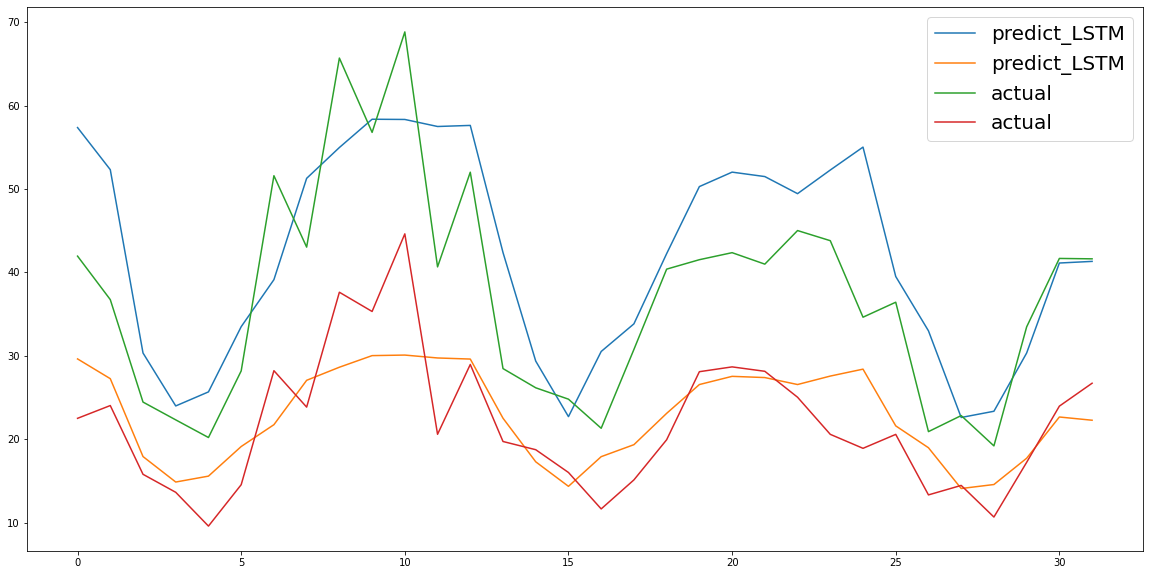

In [53]:
plt.figure(figsize=(20,10))
plt.plot(yhat2, label = "predict_LSTM")
plt.plot(testY,label = "actual")

plt.legend(prop={'size': 20})